# **Important Libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **Prepare Data**

In [2]:
def prepare_data(data_dir):
    
    filepaths = []
    labels = []
    
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            filepath = os.path.join(foldpath, file)
            filepaths.append(filepath)
            labels.append(fold)
    
    df = pd.DataFrame(data={'filepaths': filepaths, 'labels': labels})
    return df

In [3]:
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
train = prepare_data(train_dir)
train.head()

,filepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary


In [4]:
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'
test_dataset = prepare_data(test_dir)
test_dataset.head()

,filepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary


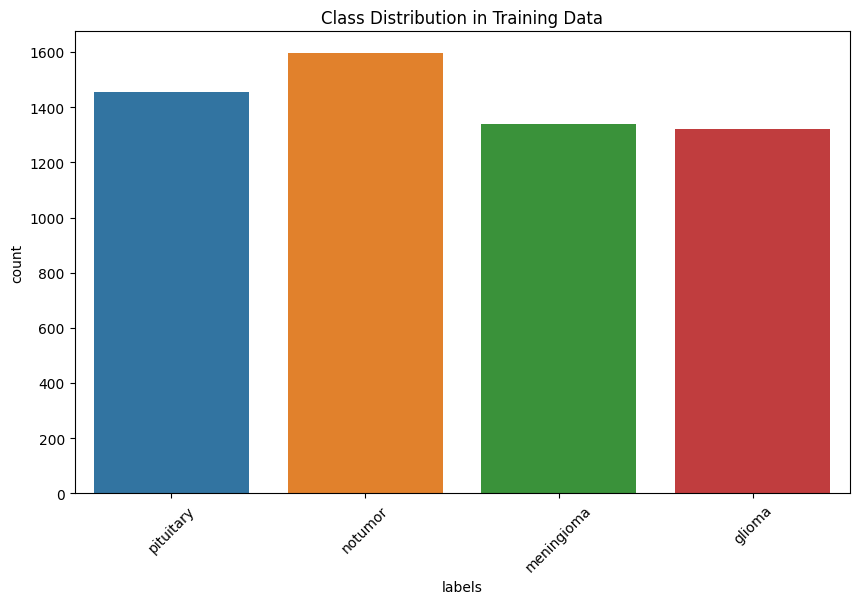

In [5]:
# Class Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=train, x='labels')
plt.title('Class Distribution in Training Data')
plt.xticks(rotation=45)
plt.show()

In [6]:
# Split the test dataset into test and validation
test, validation = train_test_split(test_dataset,test_size = 0.5,shuffle = True , random_state = 42)

In [7]:
# Shape of the datasets
train.shape, test.shape, validation.shape

((5712, 2), (655, 2), (656, 2))

In [8]:
batch_size = 16
img_size = (224, 224)

gen = ImageDataGenerator()

train_gen = gen.flow_from_dataframe( 
    train, 
    x_col= 'filepaths',
    y_col= 'labels', target_size= img_size, 
    class_mode= 'categorical',
    color_mode= 'rgb',
    shuffle= True,
    batch_size= batch_size
)

valid_gen = gen.flow_from_dataframe(
    validation, 
    x_col= 'filepaths', 
    y_col= 'labels', 
    target_size= img_size, 
    class_mode= 'categorical',
    color_mode= 'rgb', 
    shuffle= True, 
    batch_size= batch_size
)

test_gen = gen.flow_from_dataframe(
    test,
    x_col= 'filepaths',
    y_col= 'labels',
    target_size= img_size, 
    class_mode= 'categorical',
    color_mode= 'rgb', 
    shuffle= False, 
    batch_size= batch_size
)

Found 5712 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.


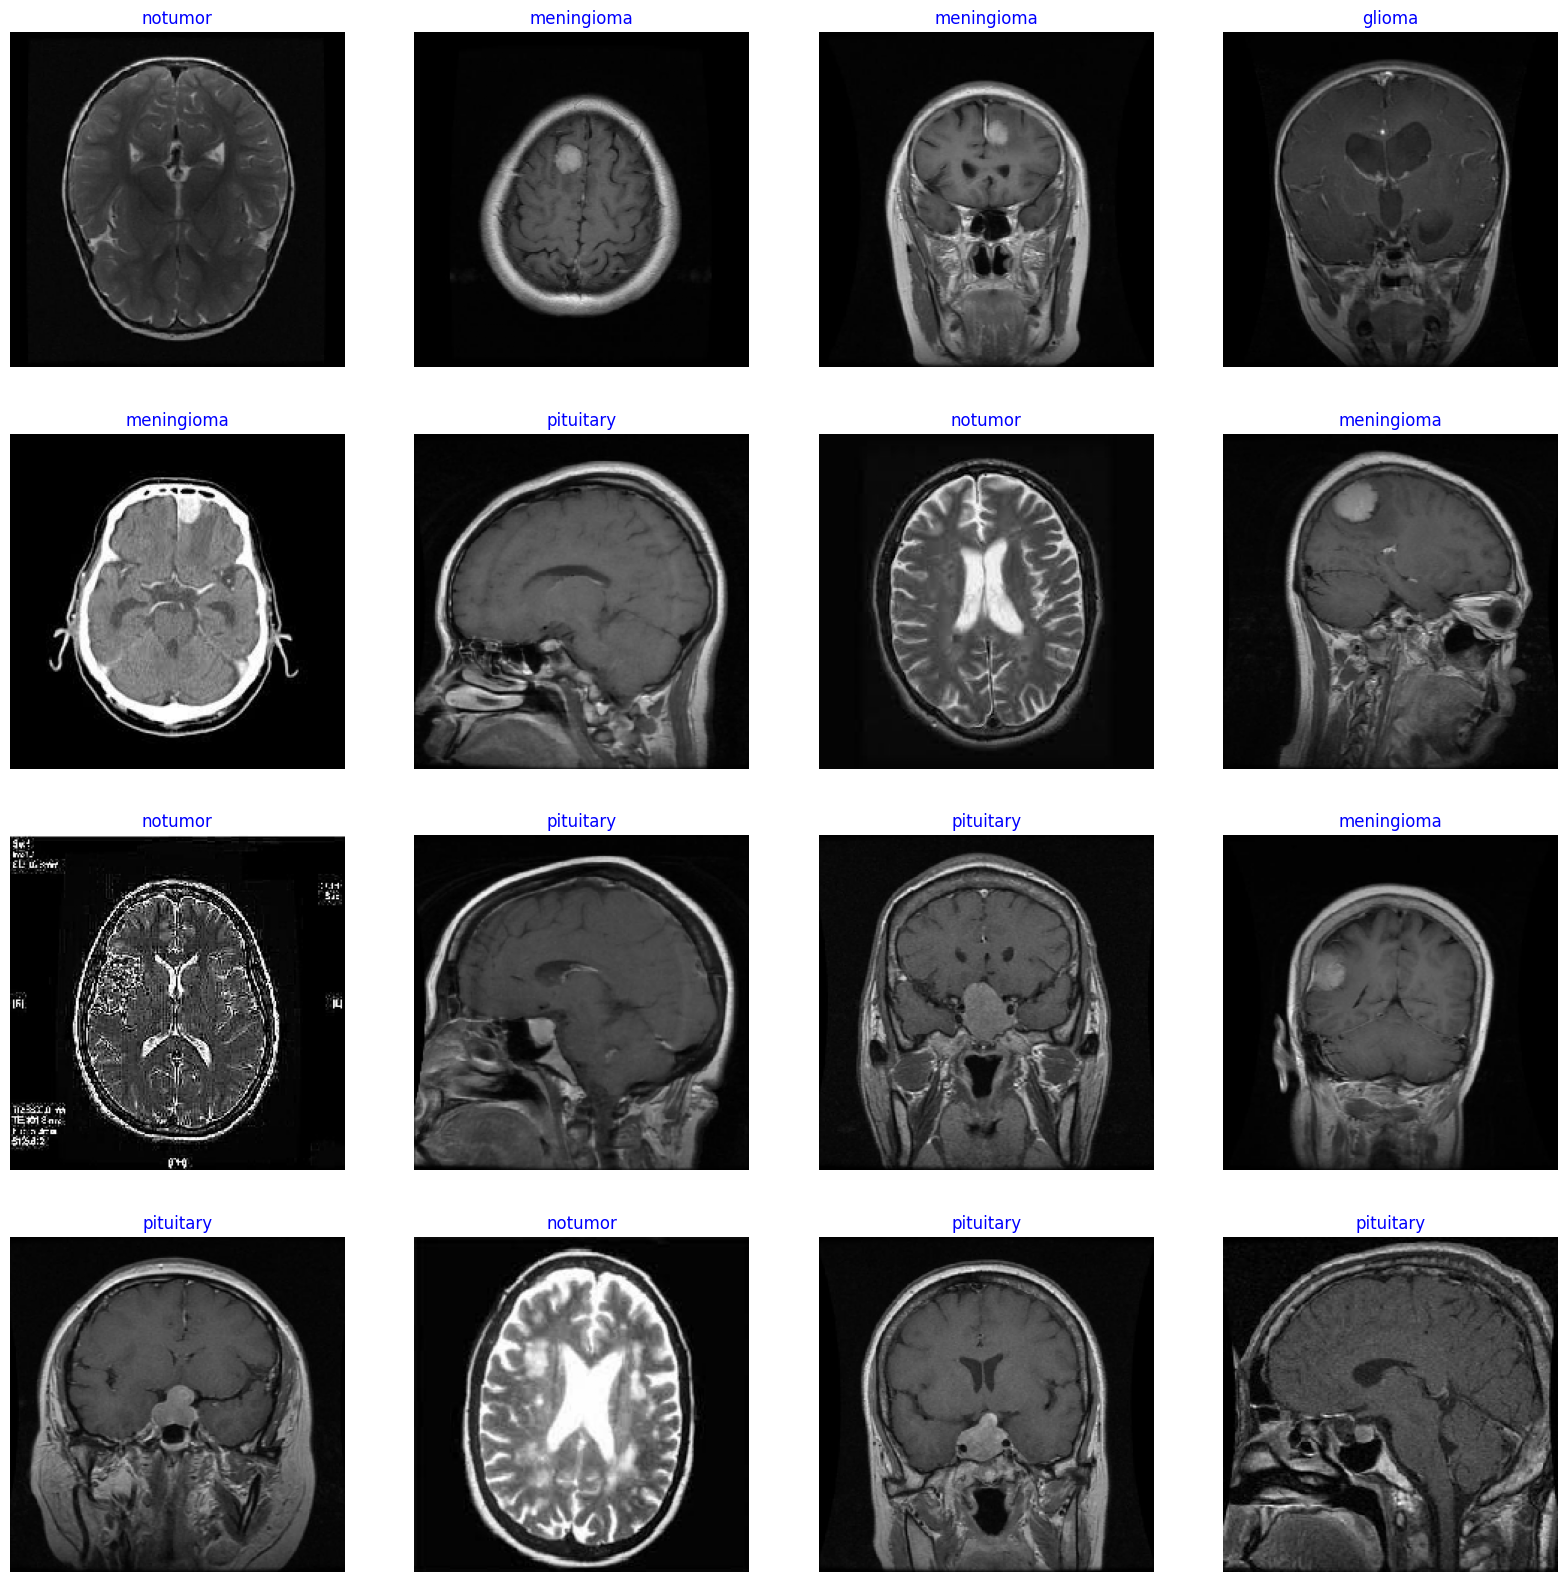

In [9]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255 
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# **Model**

In [10]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys()))

model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(class_count, activation = "softmax")
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,392,452 (115.94 MB)

 Trainable params: 30,392,452 (115.94 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(
    train_gen, 
    epochs=10, 
    validation_data=valid_gen, 
    batch_size=16
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


357/357 ━━━━━━━━━━━━━━━━━━━━ 60s 129ms/step - accuracy: 0.5952 - loss: 6.2459 - val_accuracy: 0.8323 - val_loss: 0.4573
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 35s 97ms/step - accuracy: 0.8827 - loss: 0.3288 - val_accuracy: 0.8811 - val_loss: 0.3327
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 35s 96ms/step - accuracy: 0.9295 - loss: 0.1875 - val_accuracy: 0.9116 - val_loss: 0.2344
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 34s 96ms/step - accuracy: 0.9603 - loss: 0.1168 - val_accuracy: 0.9146 - val_loss: 0.2563
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 34s 94ms/step - accuracy: 0.9763 - loss: 0.0757 - val_accuracy: 0.9558 - val_loss: 0.1469
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 35s 97ms/step - accuracy: 0.9846 - loss: 0.0472 - val_accuracy: 0.9436 - val_loss: 0.2442
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 34s 94ms/step - accuracy: 0.9938 - loss: 0.0239 - val_accuracy: 0.9436 - val_loss: 0.2928
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 34s 94ms/step - accuracy: 0.9929 - loss: 0.0201 - val_accura

# **Evaluate the Model**

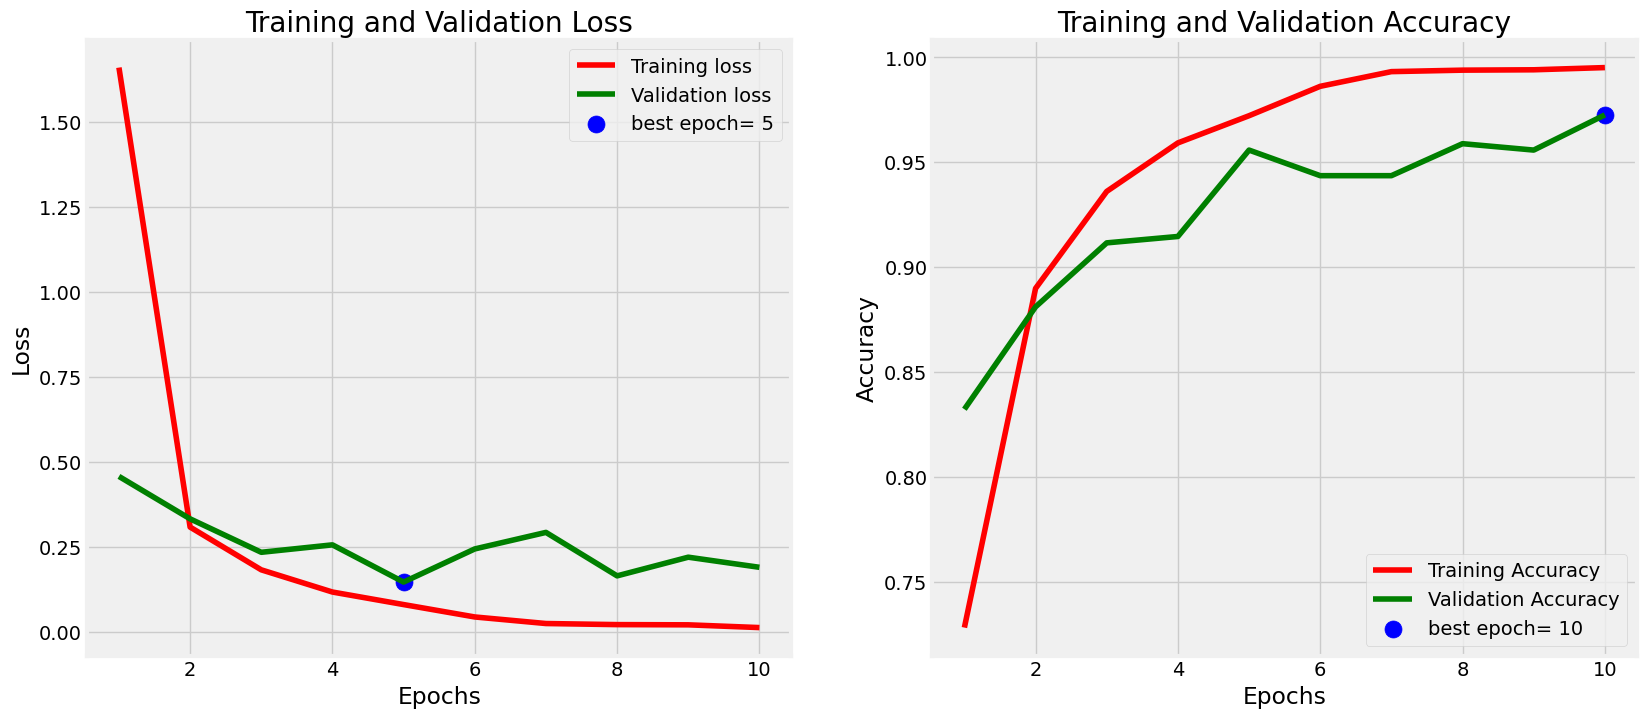

In [12]:
# Plot Accuracy and Loss
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [13]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

357/357 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.9998 - loss: 0.0014
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9673 - loss: 0.2054
 1/41 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 1.0000 - loss: 0.0225

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 225ms/step - accuracy: 0.9754 - loss: 0.1001
Train Loss:  0.001222208607941866
Train Accuracy:  0.9998249411582947
--------------------
Validation Loss:  0.19028428196907043
Validation Accuracy:  0.9725610017776489
--------------------
Test Loss:  0.10466187447309494
Test Accuracy:  0.9786259531974792


In [14]:
# Get Predictions
preds = model.predict(test_gen) 
y_pred = np.argmax(preds, axis=1) 
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step


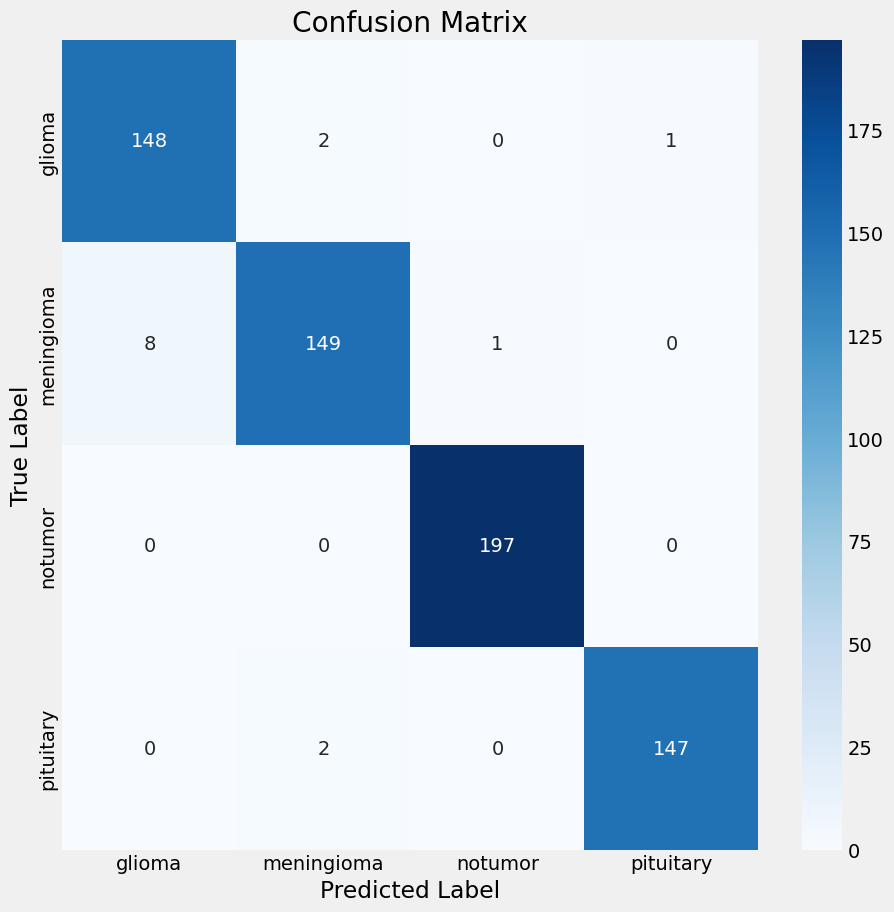

In [19]:
# Confusion Matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [16]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       0.95      0.98      0.96       151
  meningioma       0.97      0.94      0.96       158
     notumor       0.99      1.00      1.00       197
   pituitary       0.99      0.99      0.99       149

    accuracy                           0.98       655
   macro avg       0.98      0.98      0.98       655
weighted avg       0.98      0.98      0.98       655



# **Save Model**

In [17]:
#Save the model
model.save('Brain Tumor.h5')